In [3]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import pylab as pl
import math
from scipy import stats

In [4]:
# HIDDEN
baby = Table.read_table('baby.csv')

In the last chapter, we learned how to estimate an unknown numerical *parameter* such as a population mean or proportion. Our estimate was derived from a large random sample drawn from the population.

The method of estimation was based on a fundamental observation: While one sample provides a single estimate of the parameter, we know that the sample could have come out differently, and hence *the estimate could have been different*. The estimate varies, depending on the sample. 

To quantify the amount of variability in the estimate, we need a measure of how different the estimate could be across all possible samples. That measure is the standard error of the estimate. If the estimate is a sample mean or sample proportion, mathematical theory provides us with a good approximation to the standard error, using just the one sample that we have. 

But what if the estimate were a statistic other than a mean or a proportion?

Here is an example where this question arises. The table ``baby`` contains data on a random sample of 1,174 pairs of mothers and their newborn infants. Birth weight is an important factor in the health of a newborn infant – smaller babies tend to need more medical care in their first days than larger newborns. It is therefore helpful to have an estimate of birth weight before the baby is born. One way to do this is to examine the relationship between birth weight and the number of gestational days. 

We will begin by constructing a measure of this relationship. For each baby, we will calculate the ratio of birth weight to the number of gestational days. Below, the original table ``baby`` has been augmented by the column ``r_bwt_gd`` containing the values of this ratio. The first entry in that column was calcualted as follows:

$$
\frac{120~\mbox{ounces}}{284~\mbox{days}} ~\approx ~ 0.4225~ \mbox{ounces per day}
$$

In [6]:
baby['r_bwt_gd'] = baby['birthwt']/baby['gest_days']
baby

birthwt,gest_days,mat_age,mat_ht,mat_pw,m_smoker,r_bwt_gd
120,284,27,62,100,0,0.422535
113,282,33,64,135,0,0.400709
128,279,28,64,115,1,0.458781
108,282,23,67,125,1,0.382979
136,286,25,62,93,0,0.475524
138,244,33,62,178,0,0.565574
132,245,23,65,140,0,0.538776
120,289,25,62,125,0,0.415225
143,299,30,66,136,1,0.478261
140,351,27,68,120,0,0.39886


Here is a histogram of the 1,174 ratios.

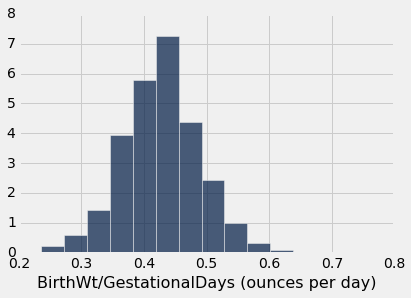

In [308]:
baby.select('r_bwt_gd').hist(bins=15,normed=True)
plots.xlabel('BirthWt/GestationalDays (ounces per day)')

At a first glance the histogram looks quite symmetric, with the density at its maximum over the interval 4 ounces per day to 4.5 ounces per day. But a closer look reveals that some of the ratios were quite large by comparison. The maximum value of the ratios was just over 0.78 ounces per day, almost double the typical value.

In [309]:
np.max(baby['r_bwt_gd'])            

0.78378378378378377

This is a situation in which the median of the distribution is more informative about the typical value than the mean, as the median is unaffected by outliers. The median in the sample is just over 0.429.

In [310]:
np.median(baby['r_bwt_gd'])         

0.42907801418439717

To estimate the median of the ratios in the population, we have to figure out how different the median might have been in another sample. But there is no helpful mathematical formula that tells us how to estimate this variability based on our sample alone.

If we knew the distribution of the population, we could replicate the sampling procedure and generate the empirical distribution of the sample median. But we don't know the distribution of the population – we don't even know its median. That's what we are trying to estimate in the first place.

What we do have is a large random sample. As we know, a large random sample is likely to resemeble the population from which it is drawn. This observation allows data scientists to *lift themselves up by their own bootstraps*: the sampling procedure can be replicated by *sampling from the sample*. 

## Resampling from the Sample

Here are the steps of *the bootstrap method* for generating an empirical histogram of the sample median.

- **Treat the sample as if it is the population.**
- **Draw from the sample**, at random **with** replacement, **the same number as the sample size**. Calculate the median.
- Do this repeatedly. You will get as many medians as the number of repetitions.
- Draw the histogram of all these medians. This is called a bootstrap empirical distribution of the sample median. It is an approximation to the probability distribution of the sample median.

It is important to resample the same number of times as the original sample size. The reason is that the estimate is based on the original sample. In order to see how much the estimate could vary, we have to compare it to estimates computed from samples of the same size. For example, the median of about 0.429 ounces per day in our sample of 1,174 babies must be compared to the medians of other samples of size 1,174.


The code below uses the method ``sample`` to draw at random with replacement from all the ratios in the original sample. Notice that the sample size does not have to be specified. By default, ``sample`` draws as many times as the number of rows in the table from which it is sampling. Since ``baby`` has one row for each baby, the default sample size of ``sample`` is exactly the number required for the bootstrap method. 

In [15]:
resample = baby.select('r_bwt_gd').sample(with_replacement=True)

The median of the resampled ratios can be computed in two ways. One way is to extract the array that is the ``r_bwt_gd`` column of the table ``resample``, and then use ``np.median``.

In [8]:
np.median(resample['r_bwt_gd'])

0.43003412969283278

The other way is to use the Table method called ``percentile`` on the table ``resample``. This method takes as it argument the percentile rank that is desired; the median is the 50th percentile.

In [9]:
resample.percentile(50)

r_bwt_gd
0.430034


To generate a bootstrap empirical distribution of the sample medians, it is necessary to replicate the sampling procedure many times. To do this easily, we will define a function called ``bootstrap_median`` that takes as its arguments the name of the table containing the original sample, the label of the column containing the variable of interest, and the number of repetitions of the resampling process. The code pertaining to the bootstrap is the same as the two lines of code used above, apart from the generic names of the arguments.

In [14]:
"""Bootstrap mpirical distribution of random sample medians, resampling from a sample
Arguments: table of original sample data, column label, number of repetitions"""

def bootstrap_median(samp_table, column_label, repetitions):
    
    # Set up an empty table to collect all the replicated medians
    medians = Table([[]], [column_label])
    
    # Run the bootstrap and place all the medians in the table
    for i in range(repetitions):
        resample = samp_table.select(column_label).sample(with_replacement=True)
        m = resample.percentile(50)
        medians.append(m.rows[0])
        
    # Display results
    medians.hist(bins=20,normed=True)
    plots.xlabel('resampled medians')
    print("Original sample median:", samp_table.select(column_label).percentile(50).rows[0][0])
    
    print("2.5 percent point of resampled medians:", medians.percentile(2.5).rows[0][0])
    print("97.5 percent point of resampled medians:", medians.percentile(97.5).rows[0][0])

Let us run 10,000 replications of the sampling procedure and look at a disribution of the resulting resampled medians.

Original sample median: 0.429078014184
2.5 percent point of resampled medians: 0.425454545455
97.5 percent point of resampled medians: 0.432727272727


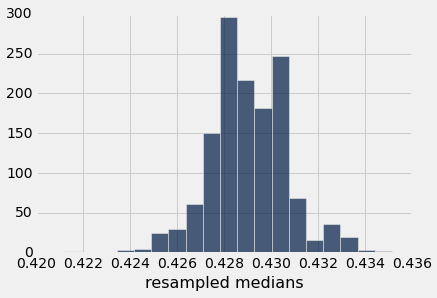

In [13]:
bootstrap_median(baby, 'r_bwt_gd', 10000)

The histogram of resampled medians is roughly bell shaped. An approximate 95%-confidence interval for the popualation median can therefore be constructed by analogy with normal confidence intervals for the sample mean: 

Eliminate the lowest 2.5% and the highest 2.5% of the resampled medians. Retain the central 95% of the resampled medians as the confidence interval. 

###Confidence Intervals: the Bootstrap Percentile Method

In other words, the left endpoint of the confidence interval is the 2.5th percentile of the resampled medians. The right endpoint has 2.5% of the resampled medians to the right of it, and so it is the 97.5th percentile of the resampled medians.

These two endpoints are provided in the display above. An approximate 95% bootstrap confidence interval for the population median is 0.4255 ounces per day to 0.4327 ounces per day.

###Notes on Using the Bootstrap

- We used the bootstrap in the previous section without giving the method a name. When we approximated the SE of the sample mean by replacing the population SD with the sample SD, we were letting the large random sample play the role of the population – that is the essence of the bootstrap method.

- To approximate the probability distribution of a statistic, it is a good idea to replicate the resampling procedure as many times as possible. A few thousand replications will result in decent approximations to the distribution of sample median, especially if the distribution of the population has one peak and is not very asymmetric. We used 10,000 replications in the example above.

- The bootstrap percentile method works well for estimating the population median based on a large random sample. However, it has limitations, as do all methods of estimation. For example, it is not expected to do well in of the following situations.
    - The goal is to estimate the minimum or maximum value in the population, or a very low or very high percentile, or most parameters that are greatly influenced by rare elements of the population.
    - The probability distribution of the statistic is not roughly normal.
    - The original sample is small.

